# 1. Importing libraries and datasets 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
import os
import tensorflow as tf
from sklearn.manifold import TSNE
from tensorflow.contrib.tensorboard.plugins import projector
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
pyLDAvis.enable_notebook()

In [4]:
data_df = pd.read_csv('process_data.csv')

In [5]:
data_df.head()

,id,year,title,text,word_count_pre,word_count_post,author_name
0,1,1987,self-organization of associative database and ...,self organization associative database applica...,3068,1830,Hisashi Suzuki
1,10,1987,a mean field theory of layer iv of visual cort...,mean field theory layer iv visual cortex appli...,2268,1320,David Brady
2,100,1988,storing covariance by the associative long-ter...,storing covariance associative long term poten...,2703,1834,Santosh S. Venkatesh
3,1000,1994,bayesian query construction for neural network...,bayesian query construction neural network mod...,2560,1672,Charles Fefferman
4,1001,1994,"neural network ensembles, cross validation, an...",neural network ensemble cross validation activ...,2983,1663,Scott Markel


# 2.Removing  missing values  

In [6]:
data_df.shape

(7241, 7)

In [7]:
data_df.isnull().sum()

id                 0
year               0
title              0
text               3
word_count_pre     0
word_count_post    0
author_name        0
dtype: int64

In [8]:
data_df.dropna(inplace=True,axis=0)

In [9]:
data_df.shape

(7238, 7)

# 3.Exploratory Data analysis of the dataset 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

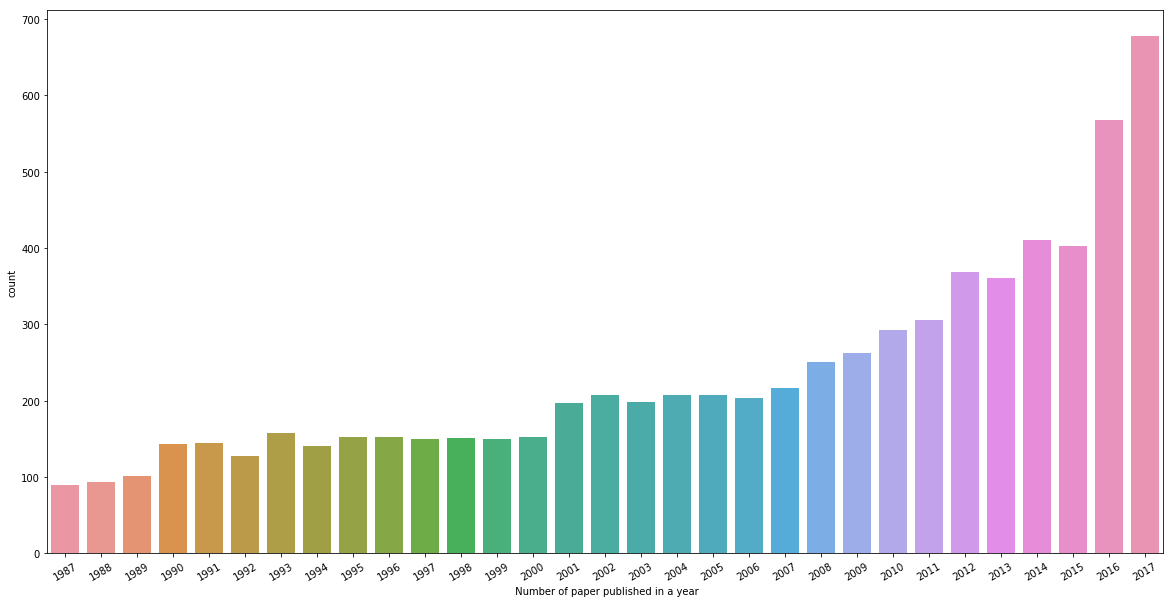

In [10]:
plt.figure(figsize=(20,10))
sns.countplot(x='year',data=data_df)
plt.xlabel(" Number of paper published in a year")
plt.xticks(rotation = 30)

* As we see from the graph as the year increases the number of research paper increases too 

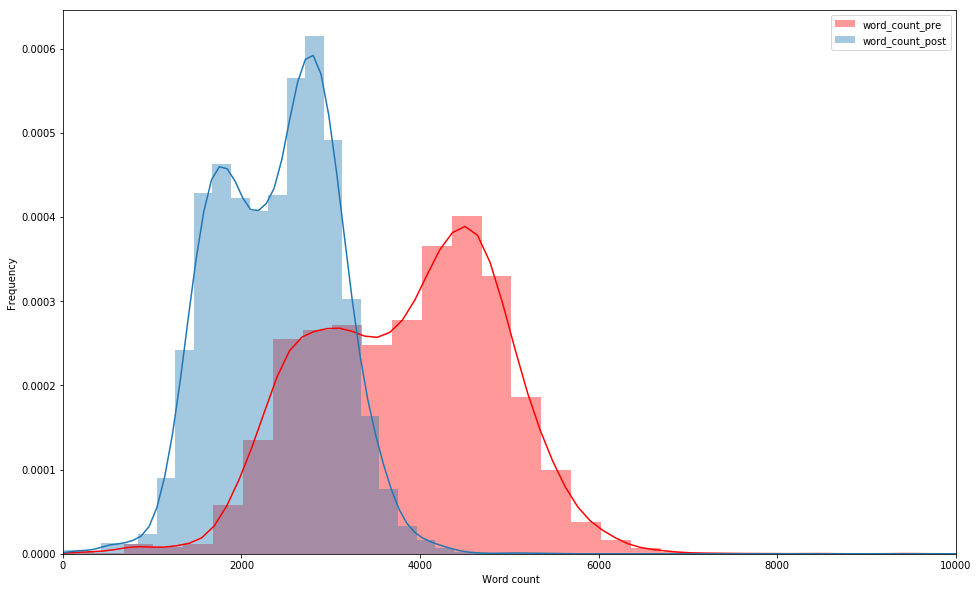

In [11]:
plt.figure(figsize=(16,10))
sns.distplot(data_df['word_count_pre'],color='red')
sns.distplot(data_df['word_count_post'])
plt.xlabel(" Word count")
plt.ylabel('Frequency')
plt.xlim([0,10000])
plt.legend(['word_count_pre','word_count_post'],loc='best')

In [12]:
def wordcloud_cluster(data_frame,columns):
    temp_df = list(data_frame[columns])
    cloud = " ".join(temp_df)
    stop_words = set(stopwords.words("english"))
    wordcloud = WordCloud(width = 1600, height = 1200, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(cloud)
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
    return plt
    

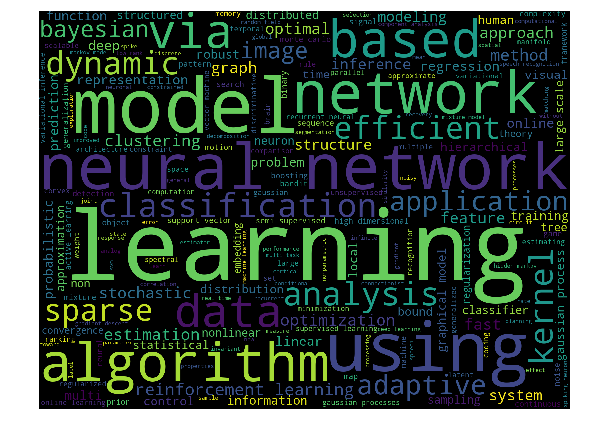

<module 'matplotlib.pyplot' from '/home/anish/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [13]:
wordcloud_cluster(data_df,'title')

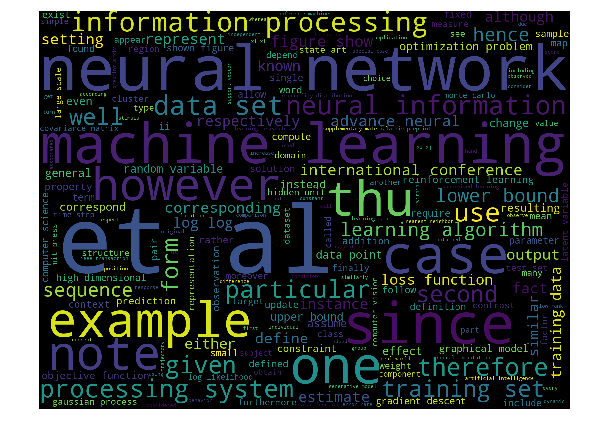

<module 'matplotlib.pyplot' from '/home/anish/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [14]:
wordcloud_cluster(data_df,'text')

* As seen from above wordcloud, title has more keywords than whole text as in text there are more part of speech tag and hence we can see the noun verb and more adjective   

In [15]:
data_df.head()

,id,year,title,text,word_count_pre,word_count_post,author_name
0,1,1987,self-organization of associative database and ...,self organization associative database applica...,3068,1830,Hisashi Suzuki
1,10,1987,a mean field theory of layer iv of visual cort...,mean field theory layer iv visual cortex appli...,2268,1320,David Brady
2,100,1988,storing covariance by the associative long-ter...,storing covariance associative long term poten...,2703,1834,Santosh S. Venkatesh
3,1000,1994,bayesian query construction for neural network...,bayesian query construction neural network mod...,2560,1672,Charles Fefferman
4,1001,1994,"neural network ensembles, cross validation, an...",neural network ensemble cross validation activ...,2983,1663,Scott Markel


# Creating Word vector  and intializing models

In [16]:
NO_FEAT  = 5000
NO_TOPIC=4
# LDA can only use raw term counts  because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_features=NO_FEAT,stop_words='english',min_df=10)
X_tf = tf_vectorizer.fit_transform(data_df['text'])
tf_feat_name = tf_vectorizer.get_feature_names()

In [17]:
lda_model = LatentDirichletAllocation(learning_method='online',random_state=23,n_components=NO_TOPIC)
lda_output =lda_model.fit_transform(X_tf)

In [18]:
pyLDAvis.sklearn.prepare(lda_model, X_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.081943 -0.039976       1        1  37.104263
3     -0.029877 -0.088101       2        1  30.297041
2     -0.146596  0.047542       3        1  17.941303
1      0.094530  0.080535       4        1  14.657394, topic_info=     Category           Freq          Term          Total  loglift  logprob
term                                                                       
2923  Default   81932.000000       network   81932.000000  30.0000  30.0000
146   Default  116380.000000     algorithm  116380.000000  29.0000  29.0000
2798  Default  152278.000000         model  152278.000000  28.0000  28.0000
4253  Default   46153.000000         state   46153.000000  27.0000  27.0000
2080  Default   49111.000000         image   49111.000000  26.0000  26.0000
2927  Default   22875.000000        neuron   22875.000000  25.0000  25.0000
3313  Default   19652.000000        policy   19652.000000  24.0000  24.0000
2200  Default   43964.000000         input   43964.000000  23.0000  23.0000
2924  Default   47350.000000        neural   47350.000000  22.0000  22.0000
4523  Default   69130.000000          time   69130.000000  21.0000  21.0000
54    Default   18580.000000        action   18580.000000  20.0000  20.0000
494   Default   39515.000000         bound   39515.000000  19.0000  19.0000
4685  Default   22854.000000          unit   22854.000000  18.0000  18.0000
3811  Default   12008.000000        reward   12008.000000  17.0000  17.0000
2476  Default  107127.000000      learning  107127.000000  16.0000  16.0000
4938  Default   16219.000000            xt   16219.000000  15.0000  15.0000
1748  Default   96916.000000      function   96916.000000  14.0000  14.0000
2458  Default   26000.000000         layer   26000.000000  13.0000  13.0000
3414  Default   72500.000000       problem   72500.000000  12.0000  12.0000
4073  Default   17380.000000        signal   17380.000000  11.0000  11.0000
2172  Default   20615.000000     inference   20615.000000  10.0000  10.0000
2669  Default   52521.000000        matrix   52521.000000   9.0000   9.0000
3675  Default   10536.000000        regret   10536.000000   8.0000   8.0000
3083  Default   27553.000000       optimal   27553.000000   7.0000   7.0000
603   Default   13110.000000          cell   13110.000000   6.0000   6.0000
3127  Default   29662.000000        output   29662.000000   5.0000   5.0000
117   Default   10047.000000         agent   10047.000000   4.0000   4.0000
4215  Default   10765.000000         spike   10765.000000   3.0000   3.0000
4497  Default   27355.000000       theorem   27355.000000   2.0000   2.0000
4740  Default   50918.000000         value   50918.000000   1.0000   1.0000
...       ...            ...           ...            ...      ...      ...
4975   Topic4    4710.843293            yt    6054.627047   1.6693  -6.1040
3393   Topic4    2224.503123         price    2560.919409   1.7794  -6.8543
4588   Topic4    5744.315099    transition    8160.032050   1.5692  -5.9056
4238   Topic4    6646.729021            st    9982.438417   1.5135  -5.7597
1065   Topic4    7859.703934      decision   12317.186844   1.4710  -5.5921
4999   Topic4    2862.521311            zt    3529.961967   1.7106  -6.6021
4291   Topic4    6513.556921      strategy   10198.740013   1.4718  -5.7799
1542   Topic4    3951.524833        expert    5637.854057   1.5648  -6.2797
4573   Topic4    4804.017859    trajectory    7418.564272   1.4857  -6.0844
146    Topic4   34004.747296     algorithm  116380.972024   0.6899  -4.1273
3083   Topic4   11733.560080       optimal   27553.165333   1.0666  -5.1914
4523   Topic4   21455.955647          time   69130.252532   0.7502  -4.5878
2476   Topic4   27574.881727      learning  107127.147524   0.5631  -4.3369
4740   Topic4   16347.497484         value   50918.862558   0.7841  -4.8598
4278   Topic4    7976.145792    stochastic   17208.479604   1

In [19]:
def visualizing_topic_cluster(model,stop_len,feat_name):
    topic={}
    for index,topix in enumerate(model.components_):
        topic[index]= [feat_name[i] for i in topix.argsort()[:-stop_len-1:-1]]
    
    return topic

In [20]:
topic_lda =visualizing_topic_cluster(lda_model,10,tf_feat_name)

In [21]:
len([print('Topic'+str(key),topic_lda[key]) for key in topic_lda])

Topic0 ['algorithm', 'function', 'problem', 'matrix', 'method', 'set', 'data', 'learning', 'result', 'bound']
Topic1 ['algorithm', 'state', 'learning', 'time', 'function', 'policy', 'action', 'value', 'problem', 'xt']
Topic2 ['network', 'input', 'model', 'neural', 'neuron', 'time', 'figure', 'unit', 'output', 'weight']
Topic3 ['model', 'data', 'image', 'feature', 'learning', 'using', 'set', 'training', 'network', 'distribution']


4

In [22]:
columns=['Topic'+ i for i in list(map(str,list(topic_lda.keys())))]

In [23]:
lda_df =pd.DataFrame(lda_output,columns=columns).apply(lambda x : np.round(x,1))

In [24]:
lda_df[columns].head(10)

,Topic0,Topic1,Topic2,Topic3
0,0.2,0.2,0.4,0.3
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.2,0.3,0.2,0.2
4,0.3,0.0,0.5,0.1
5,0.0,0.0,0.3,0.7
6,0.2,0.0,0.6,0.1
7,0.0,0.1,0.8,0.1
8,0.0,0.0,0.9,0.1
9,0.0,0.0,0.9,0.0


In [25]:
lda_df['Major_topic'] =lda_df[columns].idxmax(axis=1).apply(lambda x: int(x[-1]))

In [26]:
data_df.shape,lda_df.shape

((7238, 7), (7238, 5))

In [40]:
df_total =pd.concat(objs=(lda_df,data_df),axis=1)

In [41]:
df_total.shape

(7241, 12)

#  t-SNE  2D Visualization

In [45]:
tsne_model = TSNE(n_components=2,random_state=23)

In [46]:
vect_2D = tsne_model.fit_transform(X_tf.todense())

In [47]:
x_cor_2d=[]
y_cor_2d=[]
for x,y in vect_2D:
    x_cor_2d.append(x)
    y_cor_2d.append(y)

In [49]:
topic_no =list(lda_df['Major_topic'])

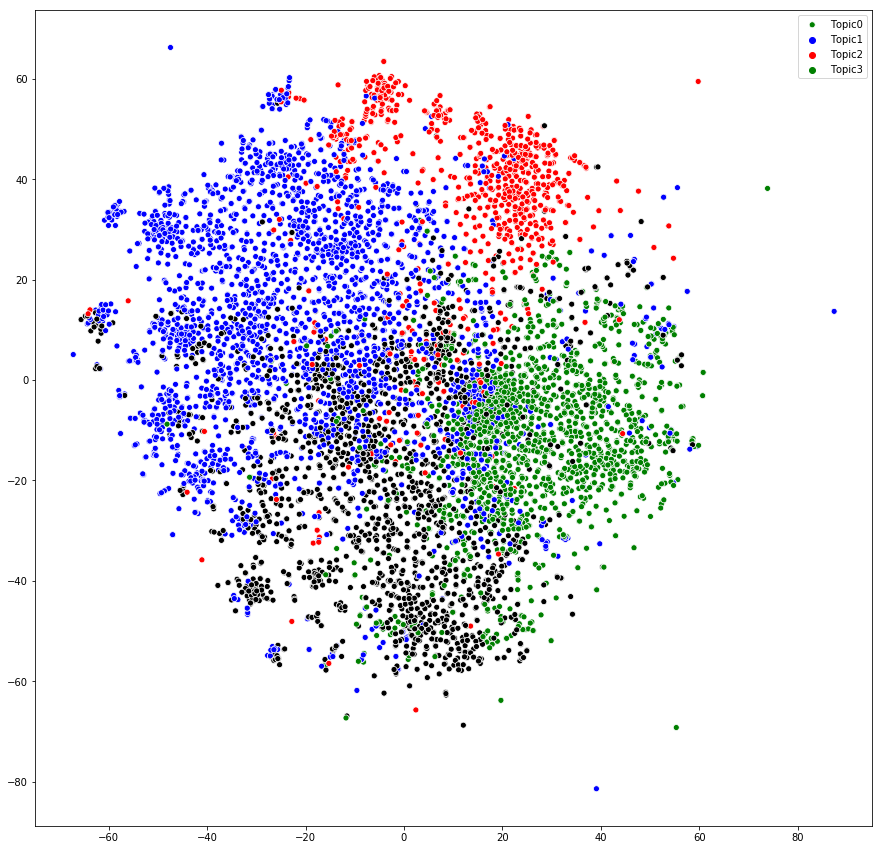

In [50]:
plt.figure(figsize=(15,15))
sns.scatterplot(x=x_cor_2d,y=y_cor_2d,hue=topic_no,palette=['blue','red','green','black'])
plt.legend(['Topic0','Topic1','Topic2','Topic3'])

# Tensorboard 3D vizualization  

In [77]:
feature_df =pd.DataFrame(X_tf.toarray())

In [78]:
feature_df.shape

(7238, 5000)

In [79]:
labels =list(lda_df['Major_topic'])

In [80]:
len(labels)

7238

In [81]:
# Path to save the embedding and checkpoints generated
LOG_DIR = 'log_file'

In [82]:
metadata = os.path.join(LOG_DIR, 'labels.tsv')

In [83]:
metadata

'log_file/labels.tsv'

In [84]:
with open(metadata, 'w') as metadata_file:
    for row in labels:
        metadata_file.write('%d\n' % row)

In [85]:
## TensorFlow Variable 
feature = tf.Variable(feature_df,name='feature')

In [86]:
with tf.Session() as sess:
    saver = tf.train.Saver([feature])

    sess.run(feature.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'feature'))   
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = feature.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = metadata
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

# Reccomendation System 

In [60]:
def rmse_calculation(x,y):
    x,y =x,y
    error=[]
    len_y =len(y)
    for i in range(len_y):
        error.append(np.sqrt(np.power((np.array(x)-np.array(y[i])),2).sum()))
    return error

In [61]:
def reccomendation(df,paper_id,col,keyword):
    paper_1 = df[(df['id']==paper_id)]
    dominant_topic = int(paper_1['Major_topic'])
    paper_2 = df[(df['Major_topic']== dominant_topic)]
    paper_2 = paper_2.drop(paper_1.index)
    x= paper_1[columns].values.tolist()
    y= paper_2[columns].values.tolist()
    error = np.round(rmse_calculation(x,y),2)
    paper_2['error'] = error
    paper_2 = paper_2[['id','title','error']].sort_values('error').head(10)
    title = list(paper_2['title'])
    error = list(paper_2['error'])
#     major_topic = list(paper_2['Major_topic'])
    print(" The title  of selected paper is  :  {}".format(list(paper_1.title)[0]))
    print(" Major Topic --- {}".format(dominant_topic))
    print("------------------------------------------------------------------------------------------------------------------------")
    #print(" The abstract of the selected topic are as follows : ")
    #print("\n",list(paper_1['abstract'])[0])
    print("------------------------------------------------------------------------------------------------------------------------")
    print(" The  keywords which is highlighted in this topic are as follows : ")
    [ print(keyword[dominant_topic][i]) for i in range(len(keyword[dominant_topic]))]
    print("------------------------------------------------------------------------------------------------------------------------")
    print(" The Recommended topic are as follows: ")
    [print(i+1,"...",title[i],"---","\n","     Error  is ","...",error[i]) for i in range(len(title))]

    print("------------------------------------------------------------------------------------------------------------------------")

In [74]:
for i in range(10,20):
    print(df_total.iloc[i]['id'])
    print(df_total.iloc[i]['title'])

1007.0
learning to play the game of chess
1008.0
multidimensional scaling and data clustering
1009.0
an experimental comparison of recurrent neural networks
101.0
training multilayer perceptrons with the extended kalman algorithm
1010.0
interference in learning internal models of inverse dynamics in humans
1011.0
active learning with statistical models
1012.0
a rapid graph-based method for arbitrary transformation-invariant pattern classification
1013.0
ocular dominance and patterned lateral connections in a self-organizing model of the primary visual cortex
1014.0
associative decorrelation dynamics: a theory of self-organization and optimization in feedback networks
1015.0
a connectionist technique for accelerated textual input: letting a network do the typing


In [76]:
reccomendation(df_total,1009,columns,topic_lda)

 The title  of selected paper is  :  an experimental comparison of recurrent neural networks
 Major Topic --- 2
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
 The  keywords which is highlighted in this topic are as follows : 
network
input
model
neural
neuron
time
figure
unit
output
weight
------------------------------------------------------------------------------------------------------------------------
 The Recommended topic are as follows: 
1 ... predicting action content on-line and in real time before action onset ? an intracranial human study --- 
      Error  is  ... 0.0
2 ... spatio-temporal hilbert maps for continuous occupancy representation in dynamic environments --- 
      Error  is  ... 0.0
3 ... a note on learning vector quantization --- 
      Error  is  ... 0.1
4 ... utili